In [12]:
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import scipy
import matplotlib
import tqdm

In [2]:
class BurstModel():
    """
    This collection of convenience functions is placed in its own class mostly to avoid function name conflicts.
    """
    def __init__(self,seq_model='None',quad_method='fixed_quad',fixed_quad_T=10,quad_order=60,quad_vec_T=np.inf):
        self.seq_model = seq_model
        self.quad_method = quad_method
        self.fixed_quad_T = fixed_quad_T
        self.quad_order = quad_order
        self.quad_vec_T = quad_vec_T
        
    def burst_intfun(self, x, g, b, beta, gamma):
        if np.isclose(beta, gamma):
            c_1 = g[0]  
            c_2 = x * beta * g[1]
        else:
            f = beta / (beta - gamma)
            c_2 = g[1] * f
            c_1 = g[0] - c_2

        U = b * (np.exp(-beta * x) * c_1 + np.exp(-gamma * x) * c_2)
        return U / (1 - U)    
    
    def eval_model_pgf(self, p_, g):
        p = 10**p_
        b, beta, gamma = p
        fun = lambda x: self.burst_intfun(x, g, b, beta, gamma)
        if self.quad_method == "quad_vec":
            T = self.quad_vec_T * (1 / beta + 1 / gamma + 1)
            gf = scipy.integrate.quad_vec(fun, 0, T)[0]
        elif self.quad_method == "fixed_quad":
            T = self.fixed_quad_T * (1 / beta + 1 / gamma + 1)
            gf = scipy.integrate.fixed_quad(fun, 0, T, n=self.quad_order)[0]
        else:
            raise ValueError("Please use one of the specified quadrature methods.")
        return gf  # this is the log-generating function

    def get_Pss(self, p, limits, samp=None):
        u = []
        mx = np.copy(limits)
        mx[-1] = mx[-1] // 2 + 1
        for i in range(len(mx)):
            l = np.arange(mx[i])
            u_ = np.exp(-2j * np.pi * l / limits[i]) - 1
            u.append(u_)
        g = np.meshgrid(*[u_ for u_ in u], indexing="ij")
        for i in range(len(mx)):
            g[i] = g[i].flatten()
        g = np.asarray(g)[:, :, None]

        if self.seq_model == "Bernoulli":
            g *= np.asarray(samp)[:, None, None]

        gf = self.eval_model_pgf(p, g)
        gf = np.exp(gf)
        gf = gf.reshape(tuple(mx))
        Pss = scipy.fft.irfftn(gf, s=tuple(limits))
        Pss = np.abs(Pss) / np.sum(np.abs(Pss))
        Pss = Pss.squeeze()
        return Pss


In [3]:
def sample_from_p(num_data_points, Pss):
    mx = Pss.shape
    p_flat = Pss.flatten()
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')    # get grid of possible values
    x_choices = np.arange(np.prod(mx))                 # represent each grid point as a point in a 1D vector
    
    samples = np.random.choice(x_choices, size=num_data_points, replace=True, p=p_flat)
    d_N, d_M = X_N.flatten()[samples], X_M.flatten()[samples]    
    return d_N, d_M


In [4]:
def get_logL_2d(data,model,bp,m_N,m_M,sr,mx,bp_is_bpn=True):
    d0,d1=data
    Pss = Pss_at_sr(model,bp,m_N,m_M,sr,mx,bp_is_bpn)
    logL = np.sum(np.log(Pss[d0,d1]))
    return logL

def Pss_at_sr(model,bp,m_N,m_M,sr,mx,bp_is_bpn=True):
#     print(bp_is_bpn)
    if sr<1:
        pn = 1
        pm = sr
    else:
        pm = 1
        pn = 1/sr
    if bp_is_bpn:
        b = bp/pn
        beta = bp/m_N
        gamma = b*pm/m_M
    else:
        b = bp/pm
        gamma = bp/m_M
        beta = b*pn/m_N
    samp = [pn,pm]
    p = np.log10([b,beta,gamma])
    return model.get_Pss(p,mx,samp)


In [5]:
# @numba.njit
def step(calc_flux, population, t, *args):
    '''
    Takes flux calculating function, past event, 
    flux, population, t, args and
    returns time to reaction and the reaction that happens
    '''
    flux = calc_flux( population, *args)[0]
    flux_sum = np.sum(flux)
    t = np.random.exponential(1. / flux_sum)
    rxn_prob = flux/flux_sum
    rxn = sample_rxns(rxn_prob)
    return rxn, t

def sample_rxns(prob_arr):
    '''
    Takes prob_arr and
    returns an randomly sampled index according to 
    the probabilities specificed in prob_arr
    '''
    num = np.random.rand()
    sent = 0
    tot = 0.
    while tot < num:
        tot = tot + prob_arr[sent]
        sent = sent + 1
    return sent - 1
# @numba.njit
def step_with_queued(calc_flux,population,t,queued_reactions,queued_reaction_times,export_arr,*args):
    '''
    Takes flux calculating function, past event, 
    flux, population, t, args and
    returns time to reaction and the reaction that happens
    '''

    if len(queued_reactions)==0:
        return step(calc_flux,population,t,*args)
    else:
        # 
        population = np.copy(population)
        population_orig = np.copy(population)
        queued_reaction_times = np.copy(queued_reaction_times)

        init_flux = calc_flux( population, *args)[0]
        n_rxn = len(init_flux)
        fluxes = np.zeros((len(queued_reactions)+1,n_rxn))
        fluxes[0] = calc_flux( population, *args)[0]
        for q in range(len(queued_reactions)):
            population += export_arr[queued_reactions[q]]
            fluxes[q+1] = calc_flux( population, *args)[0]

        queued_reaction_times = np.concatenate(([t],queued_reaction_times))
        flux_sums = fluxes[:-1] * np.diff(queued_reaction_times)[:,None]
        flux_sums = np.concatenate((np.zeros(n_rxn)[None,:],flux_sums))
        flux_cumsums = np.cumsum(flux_sums,0)
        tot_flux_cumsum = flux_cumsums.sum(1)

        u = np.random.rand()
        flux = np.log(1/u)
        
        last_ind = np.where(tot_flux_cumsum<flux)[0][-1]
        dt = queued_reaction_times[last_ind]-t
        flux_orig = np.copy(flux)
        flux -= tot_flux_cumsum[last_ind]
        dtprime = flux/fluxes[last_ind].sum()
        dt += dtprime

        flux_sum = fluxes[last_ind]
        rxn_prob = flux_sum / flux_sum.sum()
        rxn = sample_rxns(rxn_prob)   
        return rxn, dt
# def markovian_simulate(calc_flux, update, population_0, t_arr, tau, \
#                        DELAYED_SPECIES_GENERATORS, export_arr,burst_events, tau_list=None,\
#                        return_full=False,*args):

def markovian_simulate(calc_flux, update, population_0, t_arr, tau, \
                       DELAYED_SPECIES_GENERATORS, export_arr,burst_events, burst_size_time_dep, tau_list=None,\
                       return_full=False,*args):
    '''
    Takes params and
    returns matrix of the number of counts for 
    a species j at time t[i]
    '''
    if isinstance(tau , list) or isinstance(tau , tuple) :
        n_delays = len(tau)
    else:
        tau = [tau]
        n_delays = 1
        
    niter = 0

    population_arr = np.zeros((len(t_arr), update.shape[1]))
    t = t_arr[0]
    population = population_0.copy()
    population_arr[0, :] = population
    t_list = []
    population_list = []
    rxn_list = []

    t_list.append(t)
    population_list.append(population)
    
#     print(burst_events)
#     print(update)
#     raise ValueError

    # Delay time queue
    if tau_list is None:
        tau_list = [[]]*n_delays
    tau_list_delay_inds = np.asarray(sum([[j]*len(x) for j,x in enumerate(tau_list)],[]))
    tau_list_all_delays = np.concatenate(tau_list)
    tau_list_sort = np.argsort(tau_list_all_delays).astype(int)

    tau_list_delay_inds = list(tau_list_delay_inds[tau_list_sort])
    tau_list_all_delays = list(tau_list_all_delays[tau_list_sort])
    
    while t < t_arr[-1]:
        event,dt = step_with_queued(calc_flux,population,t,\
                                    tau_list_delay_inds,tau_list_all_delays,\
                                    export_arr, *args)
        

        temp_t = t + dt
        
        # Check if an export event should slot in before t + dt
        while (len(tau_list_all_delays) != 0) and (temp_t > tau_list_all_delays[0]):
            population = population + export_arr[tau_list_delay_inds[0]]
            t = tau_list_all_delays[0]
            if t>t_arr[-1]:
                break
            t_list.append(t)
            population_list.append(population)
            rxn_list.append(-tau_list_delay_inds[0]-1)
            tau_list_all_delays.pop(0) # remove element
            tau_list_delay_inds.pop(0)

        if len(tau_list_all_delays)!=len(tau_list_delay_inds):
            raise ValueError
        
        # Perform event
        t = temp_t
        if event in burst_events:
            UPD = np.copy(update[event,:])
            bs_instantaneous = burst_size_time_dep(t)
            UPD[UPD>0] = np.random.geometric(1/(1+bs_instantaneous))-1
        else:
            UPD = update[event, :]
        population = population + UPD
        t_list.append(t)
        population_list.append(population)
        rxn_list.append(event)


        for j in range(n_delays):
            if event in DELAYED_SPECIES_GENERATORS[j]:
                tau_list_all_delays.append(t + tau[j])
                tau_list_delay_inds.append(j)
        tau_list_sort = np.argsort(tau_list_all_delays).astype(int)
        tau_list_delay_inds = list(np.asarray(tau_list_delay_inds)[tau_list_sort])
        tau_list_all_delays = list(np.asarray(tau_list_all_delays)[tau_list_sort])
    
    t_only_arr = np.asarray(t_list)
    population_list= np.asarray(population_list)
    for i in range(len(t_only_arr)):
        # print(t_only_arr)
        ind = np.searchsorted(t_arr, t_only_arr[i], side = 'right')
        # print(ind)
        population_arr[ind:] = np.array(population_list[i])
    if return_full:
        return population_arr,t_only_arr,population_list,rxn_list
    else:
        return population_arr
def nondelay_wrapper(N,n,K_val,A_val,burst_size_time_dep,beta_val,gamma_val,initcond,number_of_cells=5000,simulation_time=5,ndel=50,t_arr=None,disable_tqdm=True):
# def nondelay_wrapper(N,n,K_val,A_val,b_val,beta_val,gamma_val,initcond,number_of_cells=5000,simulation_time=5,ndel=50):
#     print(beta_val)
    H,A,C,S,k,Hss,burst_events = sim_setup(N,n,K_val,A_val,beta_val,gamma_val)
#     H,A,C,S,k,Hss,burst_events = sim_setup(N,n,K_val,A_val,b_val,beta_val,gamma_val)
# 
    delayed_species = []
    DELAYED_SPECIES_GENERATORS = [[]]

    tau = []

    ####
    update_arr = S

#     print(S)
#     print(H)
#     print(A)
#     print(C)
#     print(k)
#     print(Hss)
#     print(burst_events)
    
    if t_arr is None:
        t_arr = np.linspace(0, simulation_time, ndel,endpoint=False)


    export_arr = np.zeros((len(delayed_species),N+n),dtype=int)


    samples = np.zeros((number_of_cells, len(t_arr), N+n))


    Hss = scipy.linalg.null_space(H.T)
    Hss /= Hss.sum()
    Hss = Hss.squeeze()

    for i in tqdm.tqdm(range(number_of_cells),disable=disable_tqdm):
        population_0 = np.zeros(N+n,dtype=int)
        if initcond[0][0]=='thermalized':
            init_state_prob = Hss
        elif isinstance(initcond[0][1],int):
            init_state_prob = np.zeros(N)
            jinit = initcond[0][1]
            init_state_prob[jinit] = 1
        else:
            init_state_prob = initcond[0][1]
        if N>1:
            population_0[:N] = np.random.multinomial(1,init_state_prob,1)
        else:
            population_0[:N] = 1
        initial_promoter_state = np.where(population_0[:N]==1)[0][0]

        for j,condition in enumerate(initcond[1:]):
            if isinstance(condition[0],str):
                if condition[0]=='deterministic':
                    population_0[j+N] = condition[1]
                elif condition[0]=='poisson':
                    population_0[j+N] = np.random.poisson(condition[1])
            else:
                if condition[initial_promoter_state][0]=='deterministic':
                    population_0[j+N] = condition[initial_promoter_state][1]
                elif condition[initial_promoter_state][0]=='poisson':
                    population_0[j+N] = np.random.poisson(condition[initial_promoter_state][1])
        samples[i, :, :],event_t,event_x,_ = markovian_simulate(
            propfun_generic, update_arr, population_0, t_arr, \
            tau, DELAYED_SPECIES_GENERATORS, export_arr,burst_events,burst_size_time_dep,[[]],\
            True,(k,K_val,A_val,beta_val,gamma_val,N))
    return t_arr,samples,H,A,C,init_state_prob,burst_events
def sim_setup(N,n,K_val,A_val,beta_val,gamma_val):

    H = np.zeros((N,N))
    for kv in K_val:
        H[kv[0],kv[1]] = kv[2]
    H -= np.diag(H.sum(1))

    A = np.zeros((N,n))
    for av in A_val:
        A[av[0],av[1]-1] = av[2]

    B = np.zeros((n,n))
#     print(beta_val)
    for bv in beta_val:
        B[bv[0]-1,bv[1]-1] = bv[2]
    B -= np.diag(B.sum(1))
    for gv in gamma_val:
        B[gv[0]-1,gv[0]-1] -= gv[1]
    

    Nspec = N+n
    Nrxn = len(K_val) + len(A_val) + len(gamma_val) + len(beta_val)
    S_mark = np.zeros((Nrxn,Nspec))
    k_mark = np.zeros(Nrxn)

    i=0
    burst_events = []
    for kv in K_val:
        S_mark[i,kv[0]] = -1
        S_mark[i,kv[1]] = 1
        k_mark[i] = kv[2]
        i+=1

    
#     for av,bv_ in zip(A_val,b_val):
#         if bv_ > 0:
#             burst_events += [i]
#             S_mark[i,av[1]+N-1] = bv_
#         else:
#             S_mark[i,av[1]+N-1] = 1
#         k_mark[i] = av[2]
#         i+=1

    for av in A_val:
        #note we assume there is just the one burst event! 
        burst_events += [i]
        S_mark[i,av[1]+N-1] = 1
        k_mark[i] = av[2]
        i+=1
        
    for bv in beta_val:
        S_mark[i,bv[0]+N-1] = -1
        S_mark[i,bv[1]+N-1] = 1
        k_mark[i] = bv[2]
        i+=1
        
    for gv in gamma_val:
        S_mark[i,gv[0]+N-1] = -1    
        k_mark[i] = gv[1]
        i+=1

    Hss = scipy.linalg.null_space(H.T)
    Hss /= Hss.sum()
    Hss = Hss.squeeze()

    S_mark = S_mark.astype(int)

    return H,A,B,S_mark,k_mark,Hss,burst_events
    # print(B)

def propfun_generic(x,*args):
    # print(args)
    k,K_val,A_val,beta_val,gamma_val,N = args[0]
    nRxn = len(k)
    nCells = x.shape[0]

    a = np.zeros((nCells,nRxn),dtype=float)
    x = x.T
    a = a.T
    #######
    j = 0 
    for i in range(len(K_val)):
        a[j] = k[j] * x[K_val[i][0]]
        j+=1
    for i in range(len(A_val)):
        a[j] = k[j] * x[A_val[i][0]]
        j+=1
    for i in range(len(beta_val)):
        a[j] = k[j] * x[beta_val[i][0]+N-1]
        j+=1
    for i in range(len(gamma_val)):
        a[j] = k[j] * x[gamma_val[i][0]+N-1]
        j+=1
    # print(a)
    # print(x)
    # raise ValueError
    return a.T


In [9]:
np.random.seed(2813308004)
N = 1
n = 2
K_val = []

max_val = np.inf


b=10
k = 0.2
beta = 1
gamma = 0.8
A_val =[[0,1,k]]
beta_val = [[1,2,beta]]
gamma_val = [[2,gamma]]
burst_size_time_dep = lambda t: b
# muN0 = b*k/beta
# muM0 = b*k/gamma
n_cells = 1000
switch_times=[0]
tvec = np.linspace(0,T)

In [13]:
# while max_val>max_state_space_size:
#     rands = 10**(np.clip(np.random.randn(6)*norm_std+norm_mean,-1.4,1.4))
#     burst_size_values = list(rands[:3])
#     k, beta, gamma = rands[3:]
#     max_B = np.max(burst_size_values)
#     max_mean = max_B*k*np.asarray([1/beta,1/gamma])
#     max_std = np.sqrt(max_mean*(1+ max_B*np.asarray([1,beta/(beta+gamma)])))
#     max_domain = max_mean + 4*max_std
#     max_val = max_domain.max()





T = 10/np.min([k,beta,gamma])

initcond = [['thermalized'],
            ['deterministic',0],
            ['deterministic',0]]
t_arr,samples,H,A,C,init_state_prob,burst_events = nondelay_wrapper(N,n,K_val,A_val,burst_size_time_dep,beta_val,gamma_val,
                                                                    initcond,
                                                                    simulation_time=T,number_of_cells=n_cells,
                                                                    t_arr = tvec,disable_tqdm=True)


In [28]:
X = samples[:,-1,1:].astype(int).T

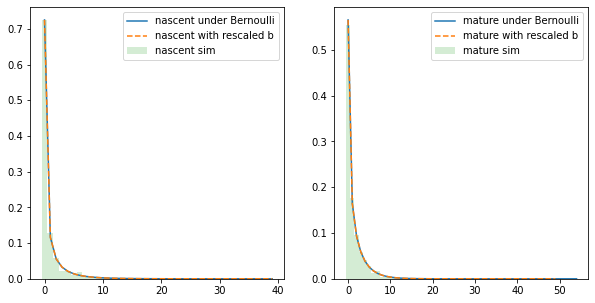

In [35]:
fig1,ax1= plt.subplots(1,2,figsize=(10,5))

mx = X.max(1)+10
x = np.arange(mx[0])
burst_model = BurstModel('None')
samp = [0.4,0.5]
p = np.log10(np.asarray([b,beta/k,gamma/k]))
X_downsampled = np.zeros_like(X)
X_downsampled[0,:] = np.random.binomial(X[0,:],samp[0])
X_downsampled[1,:] = np.random.binomial(X[1,:],samp[1])
burst_model = BurstModel('Bernoulli')
Pss = burst_model.get_Pss(p,mx,samp)

ax1[0].plot(Pss.sum(1),label='nascent under Bernoulli')
y = scipy.stats.nbinom.pmf(x,k/beta,1/(1+b*samp[0]))
ax1[0].plot(x,y,'--',label='nascent with rescaled b')
bins = x-0.5
ax1[0].hist(X_downsampled[0],bins,alpha=0.2,density=True,label='nascent sim')

burst_model = BurstModel('None')
Pss_ = burst_model.get_Pss(np.log10(np.asarray([b*samp[1],beta/k,gamma/k])),[1,50])
ax1[1].plot(Pss.sum(0),label='mature under Bernoulli')
ax1[1].plot(Pss_,'--',label='mature with rescaled b')
_=ax1[1].hist(X_downsampled[1],bins,alpha=0.2,density=True,label='mature sim')

ax1[0].legend()
ax1[1].legend()


In [27]:
# X.shape

(1000, 2)